# What-if Scenario Evaluation for Carbon Sequestration using Data Manager for Agriculture to Provide Farming Data

**IMPORTANT**. It is recommended to first read and execute the individual notebooks [azure_data_manager_for_agriculture_example](./azure_data_manager_for_agriculture_example.ipynb) and [carbon/whatif](../carbon/whatif.ipynb) to understand how FarmVibes.AI communicates with [Microsoft Data Manager for Agriculture](https://aka.ms/farmvibesDMA) and [COMET-Farm API](https://gitlab.com/comet-api/api-docs/-/tree/master/) respectively.

This notebook shows how to use  [Microsoft Data Manager for Agriculture](https://aka.ms/farmvibesDMA) (Data Manager for Agriculture) and the [COMET-Farm API](https://gitlab.com/comet-api/api-docs/-/tree/master/)  to derive carbon sequestration information for agricultural fields. The idea is to obtain farming data from Data Manager for Agriculture and input this data directly into the COMET-Farm API. In this notebook, we use a single workflow to calculate soil carbon sequestration using Data Manager for Agriculture ids. The steps executed by the `farm_ai/admag/admag_carbon_integration` are the following:

1. FarmVibes.AI needs the farmer_id, boundary_id, and a seasonal_field_id (`ADMAgSeasonalFieldInput`), to retrieve farming data from Azure Data Manager for Agriculture. 

2. The Information is sent back to FarmVibes.AI (Tillage, Fertilization, Organic Amendments, Planting, Harvest, …).

3. FarmVibes.AI creates two List of SeasonFieldInformation. Baseline describing how the farm was conducted in the previous years and Scenario which provides the whatif scenarios for [COMET-Farm API](https://gitlab.com/comet-api/api-docs/-/tree/master/). As `SeasonFieldInformation` is subclass of DataVibe, it can be used to run other workflows presented in FarmVibes.AI.

4. Convert the lists of `SeasonFieldInformation` to XML and make a request to [COMET-Farm API](https://gitlab.com/comet-api/api-docs/-/tree/master/).

5. [COMET-Farm API](https://gitlab.com/comet-api/api-docs/-/tree/master/) returns the carbon offset information.

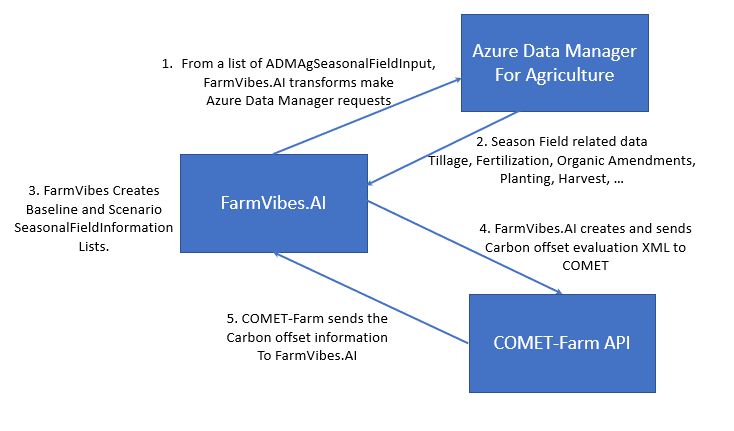

## Import Required Libraries

In [ ]:
import os
from typing import List
from datetime import datetime, timezone

from vibe_core.datamodel import RunStatus
from vibe_core.client import FarmvibesAiClient, get_default_vibe_client, get_local_service_url
from vibe_core.data import ADMAgSeasonalFieldInput

## Define a list of objects to be retrieved from Data Manager for Agriculture

In the next cells, we define the `ADMAgSeasonalFieldInput` lists and the workflow parameters. Please, check the notebooks [azure_data_manager_for_agriculture_example](./azure_data_manager_for_agriculture_example.ipynb) and [carbon/whatif](../carbon/whatif.ipynb) for details related to Data Manager for Agriculture and COMET-Farm API access variables.

In [ ]:
# Azure Data Manager for Agriculture host
BASE_URL = ""
# Azure Data Manager for Agriculture client id
CLIENT_ID = ""
# Azure Data Manager for Agriculture client secret
CLIENT_SECRET = "@SECRET(eywa-secrets, data-manager-ag-secret)"
# Azure Data Manager for Agriculture authority
AUTHORITY = ""
# Azure Data Manager for Agriculture default scope
DEFAULT_SCOPE = ""
# Farmer Azure Data Manager for Agriculture ID
FARMER_ID = ""
# Boundary Azure Data Manager for Agriculture ID
BOUNDARY_ID = ""
# A list of seasonal field scenarios ids from Data Manager for Agriculture
SCENARIO_IDS = []
# A list of baseline seasonal field ids from Data Manager for Agriculture
BASELINE_IDS = []
# COMET Registered Email. Visit the site https://comet-farm.com/ to 
# check how to get registered emails.
COMET_REGISTERED_EMAIL = ""
# NGROK Authorization token. Check ngrok website to check how to obtain
# an authorization token.
NGROK_AUTH_TOKEN = ""

In [ ]:
def get_seasonal_field_inputs(
    farmer_id: str,
    boundary_id: str,
    seasonal_field_ids: List[str]
) -> List[ADMAgSeasonalFieldInput]:
    return [
        ADMAgSeasonalFieldInput(
            farmer_id=FARMER_ID,
            boundary_id=BOUNDARY_ID,
            seasonal_field_id=seasonal_field_id
        )
        for seasonal_field_id in seasonal_field_ids
    ]

baseline_admag_inputs = get_seasonal_field_inputs(FARMER_ID, BOUNDARY_ID, BASELINE_IDS)
scenario_admag_inputs = get_seasonal_field_inputs(FARMER_ID, BOUNDARY_ID, SCENARIO_IDS)

### Get FarmVibes.AI Client

In [ ]:
client: FarmvibesAiClient = get_default_vibe_client()

# Azure Data Manager for Agriculture and COMET-Farm API Workflow



In [ ]:
CARBON_WORKFLOW = "farm_ai/admag/admag_carbon_integration"

In [ ]:
client.document_workflow(CARBON_WORKFLOW)

In [ ]:
run = client.run(
    CARBON_WORKFLOW,
    "Carbon what-if scenario",
    input_data={
        "baseline_admag_input": baseline_admag_inputs,
        "scenario_admag_input": scenario_admag_inputs,
    },
    parameters={
        "base_url": BASE_URL,
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "authority": AUTHORITY,
        "default_scope": DEFAULT_SCOPE,
        "ngrok_token": NGROK_AUTH_TOKEN,
        "comet_support_email": COMET_REGISTERED_EMAIL
    }
)

run.monitor()

# Show the carbon output

In [ ]:
run.output['carbon_output'][0].carbon